In [1]:
%%capture
# Run to set environment variables if want to
# %env HF_TOKEN=

In [1]:
# global imports
from probe_gen.paths import data

# Generate and save perplexities

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from probe_gen.config import MODELS

# Load model and tokenizer
model_name = "llama_3b"
tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name])
model = AutoModelForCausalLM.from_pretrained(MODELS[model_name], device_map="auto")
# If no pad token is set, reuse the EOS token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
from probe_gen.analysis import calculate_response_perplexities_batched, save_perplexities
from probe_gen.config import ACTIVATION_DATASETS
from probe_gen.gen_data.utils import load_jsonl_data

# Get perplexity data
behaviour = 'science'
for dataset_type in [f'{model_name}_5k', f'{model_name}_prompted_5k', f'qwen_3b_5k']:
# for dataset_type in [f'{model_name}_5k', f'{model_name}_prompted_5k', f'ministral_8b_5k']:
    dataset_name = ACTIVATION_DATASETS[f"{behaviour}_{dataset_type}"]["labels_filename"]
    human_list, assistant_list, _ = load_jsonl_data(dataset_name)
    perplexities = calculate_response_perplexities_batched(model, tokenizer, human_list, assistant_list, batch_size=16)
    save_perplexities(perplexities, behaviour, model_name, dataset_type)

100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


# Load and visualize perplexities

In [13]:
from probe_gen.analysis import load_perplexities

model_name = 'llama_3b'
behaviour = 'science'
perplexities_on = load_perplexities(behaviour, model_name, f'{model_name}_5k')
perplexities_on_prompted = load_perplexities(behaviour, model_name, f'{model_name}_prompted_5k')
perplexities_off = load_perplexities(behaviour, model_name, f'qwen_3b_5k')
# perplexities_off = load_perplexities(behaviour, model_name, f'ministral_8b_5k')

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [14]:
# TODO: Filter out empty responses in dataset generation pipeline instead of here

import numpy as np

def filter_out_nans(data):
    arr = np.array(data)
    arr = arr[np.isfinite(arr)]
    if len(arr) != len(data):
        print(f"Had to reduce data from length {len(data)} to {len(arr)} to filter out NaNs.")
    return arr

perplexities_on = filter_out_nans(perplexities_on)
perplexities_on_prompted = filter_out_nans(perplexities_on_prompted)
perplexities_off = filter_out_nans(perplexities_off)

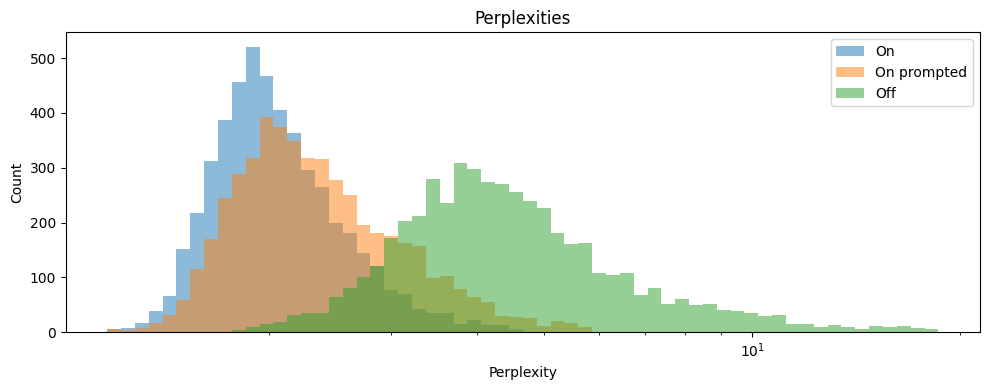

In [15]:
from probe_gen.analysis import plot_perplexities

plot_perplexities(
    [perplexities_on, perplexities_on_prompted, perplexities_off], 
    ['On', 'On prompted', 'Off'], 
    remove_outliers=True, 
    num_bins=60
)